# Dataset

The file contains information about a test matrix of solvers and graphs. Specifically, it reports the time in milliseconds for each run, the memory usage\* in MB, whether the graph was colored successfully, and how many colors it took.

\*: the memory usage is not reported correctly because the glibc allocator sometimes does not free memory in order to reuse it later.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

rgg_data = pd.read_csv("rgg-graphs.csv", sep=";")
rgg_data.head()

,Graph,Vertices,Edges,Solver,Time elapsed,Memory usage,Success,Colors
0,rgg_n_2_15_s0.graph.fast,32768,342581,SequentialSolver,20.18,8.26,1,15
1,rgg_n_2_15_s0.graph.fast,32768,342581,LubySolver (1 threads),195.71,11.85,1,14
2,rgg_n_2_15_s0.graph.fast,32768,342581,LubySolver (2 threads),153.96,8.13,1,14
3,rgg_n_2_15_s0.graph.fast,32768,342581,LubySolver (4 threads),152.61,16.26,1,14
4,rgg_n_2_15_s0.graph.fast,32768,342581,JonesSolver (1 threads),19.93,0.16,1,15


# Correctness

We confirm empirically that all solvers were implemented correctly. Nevertheless, some use more colors than others: it seems that LDF is the best solver in this regard, and Luby is the worst. Notice that the number of colors may differ for the same algorithm with a different number of threads.

In [2]:
print("Graphs colored incorrectly:", sum(rgg_data["Success"] == 0))
pd.DataFrame(rgg_data.groupby(["Graph", "Solver"]).apply(lambda df: df["Colors"])).reset_index(level=2, drop=True).unstack()

Graphs colored incorrectly: 0


Colors                          \
Solver                   JonesSolver (1 threads) JonesSolver (2 threads)   
Graph                                                                      
rgg_n_2_15_s0.graph.fast                      15                      15   
rgg_n_2_16_s0.graph.fast                      17                      17   
rgg_n_2_17_s0.graph.fast                      16                      16   
rgg_n_2_18_s0.graph.fast                      19                      19   
rgg_n_2_19_s0.graph.fast                      19                      19   
rgg_n_2_20_s0.graph.fast                      20                      20   
rgg_n_2_21_s0.graph.fast                      22                      22   
rgg_n_2_22_s0.graph.fast                      22                      22   
rgg_n_2_23_s0.graph.fast                      23                      23   
rgg_n_2_24_s0.graph.fast                      24                      24   

                                                                        \
Solver                   JonesSolver (4 threads) LDFsolver (1 threads)   
Graph                                                                    
rgg_n_2_15_s0.graph.fast                      15                    14   
rgg_n_2_16_s0.graph.fast                      17                    15   
rgg_n_2_17_s0.graph.fast                      16                    16   
rgg_n_2_18_s0.graph.fast                      19                    17   
rgg_n_2_19_s0.graph.fast                      19                    19   
rgg_n_2_20_s0.graph.fast                      20                    19   
rgg_n_2_21_s0.graph.fast                      22                    20   
rgg_n_2_22_s0.graph.fast                      22                    21   
rgg_n_2_23_s0.graph.fast                      23                    23   
rgg_n_2_24_s0.graph.fast                      24                    22   

                                                                        \
Solver                   LubySolver (1 threads) LubySolver (2 threads)   
Graph                                                                    
rgg_n_2_15_s0.graph.fast                     14                     14   
rgg_n_2_16_s0.graph.fast                     17                     16   
rgg_n_2_17_s0.graph.fast                     17                     16   
rgg_n_2_18_s0.graph.fast                     18                     18   
rgg_n_2_19_s0.graph.fast                     19                     20   
rgg_n_2_20_s0.graph.fast                     20                     21   
rgg_n_2_21_s0.graph.fast                     21                     20   
rgg_n_2_22_s0.graph.fast                     21                     23   
rgg_n_2_23_s0.graph.fast                     25                     22   
rgg_n_2_24_s0.graph.fast                     24                     26   

                                                                  
Solver                   LubySolver (4 threads) SequentialSolver  
Graph                                                             
rgg_n_2_15_s0.graph.fast                     14               15  
rgg_n_2_16_s0.graph.fast                     16               17  
rgg_n_2_17_s0.graph.fast                     17               16  
rgg_n_2_18_s0.graph.fast                     19               18  
rgg_n_2_19_s0.graph.fast                     19               19  
rgg_n_2_20_s0.graph.fast                     20               22  
rgg_n_2_21_s0.graph.fast                     21               20  
rgg_n_2_22_s0.graph.fast                     21               23  
rgg_n_2_23_s0.graph.fast                     24               23  
rgg_n_2_24_s0.graph.fast                     25               24

# Time elapsed (log-log plot)

We observe that there is a very noticeable difference (approx. 1 order of magnitude) between Luby solvers and other algorithms. Furthermore, at small sizes these algorithms are comparable in their speed, but as the number of vertices increases we can see a further subdivision - multithread Jones performs the best, followed by single-thread Jones and LDF, followed by the sequential algorithm.

<IPython.core.display.Javascript object>


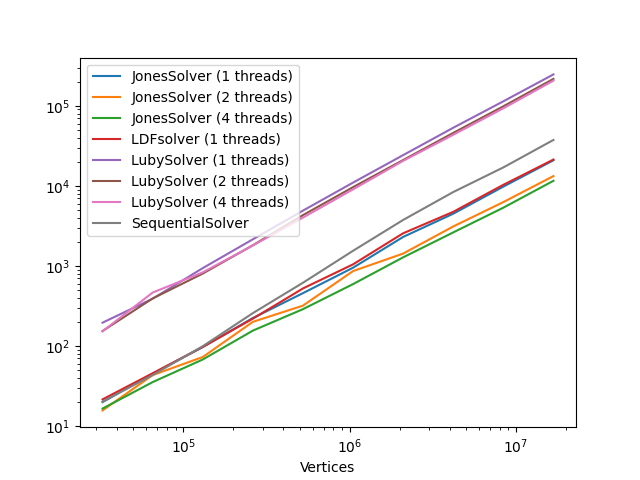

In [3]:
%matplotlib notebook

rgg_by_solver = rgg_data.groupby("Solver")
fig, ax = plt.subplots()
for solver_name, data in rgg_by_solver:
    data.plot(ax=ax, x="Vertices", y="Time elapsed", loglog=True, label=solver_name)

# Nodes per second

We can see that at small graph sizes, Jones performs very well with multiple threads, but so do sequential solvers - with the advantage of being significantly simpler.

As the graph size increases we observe several interesting trends (many of which can be seen in the log-log plot and now quantified):

 - Jones' solver is clearly the best performer;
 - Multi-thread Jones achieves a better speedup over single-thread with respect to lower sizes;
 - the LDF heuristic for sequential solvers scales significantly better than the random one (1.9x vs 3.6x slowdown).

In [4]:
pd.DataFrame(rgg_data.groupby(["Graph", "Solver"]).apply(lambda df: df["Vertices"]/df["Time elapsed"])).reset_index(level=2, drop=True).unstack().astype(int)
#rgg_data.groupby(["Graph", "Solver"]).head()

0                          \
Solver                   JonesSolver (1 threads) JonesSolver (2 threads)   
Graph                                                                      
rgg_n_2_15_s0.graph.fast                    1644                    2085   
rgg_n_2_16_s0.graph.fast                    1452                    1513   
rgg_n_2_17_s0.graph.fast                    1349                    1797   
rgg_n_2_18_s0.graph.fast                    1172                    1308   
rgg_n_2_19_s0.graph.fast                    1146                    1641   
rgg_n_2_20_s0.graph.fast                    1103                    1215   
rgg_n_2_21_s0.graph.fast                     911                    1470   
rgg_n_2_22_s0.graph.fast                     934                    1348   
rgg_n_2_23_s0.graph.fast                     857                    1337   
rgg_n_2_24_s0.graph.fast                     804                    1267   

                                                                        \
Solver                   JonesSolver (4 threads) LDFsolver (1 threads)   
Graph                                                                    
rgg_n_2_15_s0.graph.fast                    1978                  1519   
rgg_n_2_16_s0.graph.fast                    1849                  1434   
rgg_n_2_17_s0.graph.fast                    1930                  1346   
rgg_n_2_18_s0.graph.fast                    1683                  1193   
rgg_n_2_19_s0.graph.fast                    1817                  1001   
rgg_n_2_20_s0.graph.fast                    1768                  1002   
rgg_n_2_21_s0.graph.fast                    1637                   820   
rgg_n_2_22_s0.graph.fast                    1600                   885   
rgg_n_2_23_s0.graph.fast                    1571                   814   
rgg_n_2_24_s0.graph.fast                    1451                   787   

                                                                        \
Solver                   LubySolver (1 threads) LubySolver (2 threads)   
Graph                                                                    
rgg_n_2_15_s0.graph.fast                    167                    212   
rgg_n_2_16_s0.graph.fast                    168                    166   
rgg_n_2_17_s0.graph.fast                    139                    163   
rgg_n_2_18_s0.graph.fast                    121                    144   
rgg_n_2_19_s0.graph.fast                    106                    121   
rgg_n_2_20_s0.graph.fast                     95                    108   
rgg_n_2_21_s0.graph.fast                     86                     99   
rgg_n_2_22_s0.graph.fast                     78                     91   
rgg_n_2_23_s0.graph.fast                     73                     85   
rgg_n_2_24_s0.graph.fast                     68                     77   

                                                                  
Solver                   LubySolver (4 threads) SequentialSolver  
Graph                                                             
rgg_n_2_15_s0.graph.fast                    214             1623  
rgg_n_2_16_s0.graph.fast                    140             1509  
rgg_n_2_17_s0.graph.fast                    157             1318  
rgg_n_2_18_s0.graph.fast                    145             1018  
rgg_n_2_19_s0.graph.fast                    130              850  
rgg_n_2_20_s0.graph.fast                    116              678  
rgg_n_2_21_s0.graph.fast                    102              558  
rgg_n_2_22_s0.graph.fast                     96              501  
rgg_n_2_23_s0.graph.fast                     90              493  
rgg_n_2_24_s0.graph.fast                     81              448

# Parser

We immediately see that FastParser provides a significant and consistent performance improvement of about 5x, even over a multithreaded version of the DIMACS-10 parser.

In [5]:
fastparser_data = pd.read_csv("parse-fast.csv", sep=";", names=["Graph", "Vertices", "Edges", "Time (ms)"])
fastparser_data["Parser"] = "FastParser"
fastparser_data["Graph"] = fastparser_data["Graph"].apply(lambda file: file[:-5])
dimacs10parser_data = pd.read_csv("parse-slow.csv", sep=";", names=["Graph", "Vertices", "Edges", "Time (ms)"])
dimacs10parser_data["Parser"] = "DIMACS-10"
parser_data = pd.concat([fastparser_data, dimacs10parser_data])
pd.DataFrame(parser_data.groupby(["Graph", "Parser"]).apply(lambda df: df["Time (ms)"])).reset_index(level=2, drop=True).unstack()

Time (ms)           
Parser              DIMACS-10 FastParser
Graph                                   
rgg_n_2_15_s0.graph        83          8
rgg_n_2_16_s0.graph       102         20
rgg_n_2_17_s0.graph       256         45
rgg_n_2_18_s0.graph       476         86
rgg_n_2_19_s0.graph       870        185
rgg_n_2_20_s0.graph      1939        365
rgg_n_2_21_s0.graph      3363        751
rgg_n_2_22_s0.graph      7353       1632
rgg_n_2_23_s0.graph     15728       3294
rgg_n_2_24_s0.graph     32710       6352

# Conclusions

The choice of algorithm results in vastly different performances. Early multithread algorithms found in literature may perform significantly worse than simpler single-thread ones, and thus be only of theoretical interest; more recent ones typically provide a measurable speedup.

At the same time, one must not forget that efficient algorithms and techniques can provide a speedup simply at the expense of additional complexity or memory usage. The case of FastParser provides a strong argument for efficient algorithms; the case of JonesSolver shows that at times multithreading can beat even the sequential solver with the best heuristics.

Ultimately, the question of whether to parallelize an algorithm or to implement a new one is hard to answer a priori, and the decision must be driven by profiling and experimentation.